In [1]:
import mysql.connector
import pandas as pd
from pandas import DataFrame
from mysql.connector import errorcode
 
config = {
'user': 'db_gtown_2018',
'password': 'Gtown2018',
'port': '3306',
'host': 'nflnumbers.czuayagz62va.us-east-1.rds.amazonaws.com',
'database': 'db_nfl',
'raise_on_warnings': True,
}
 
try:
    cnx = mysql.connector.connect(**config)
    cursor = cnx.cursor()
    #Let's read all the rows in the table
    readContactPerson = """SELECT 
    FGXP,
    PBP.FKICKER,
    PNAME AS KICKER_NAME,
    DIST,
    QTR,
    MIN,
    TIMO AS TIMO_REMAIN,
    CASE
        WHEN GOOD = 'Y' THEN 1
        ELSE 0
    END AS SUCCESS,
    CASE
        WHEN DETAIL LIKE '%BLOCKED%' THEN 1
        ELSE 0
    END AS BLOCKED,
    CASE
        WHEN DPOS = 0 THEN 'UNDRAFTED'
        ELSE DPOS
    END AS DRAFT_POSITION,
    DIST - (100 - CASE
        WHEN YFOG = '' THEN '98'
        ELSE YFOG
    END) AS YDS_BEHIND_LOS,
    PTSO - PTSD AS POINT_DIFFERENTIAL,
    CASE
        WHEN
            QTR IN ('2' , '4') AND MIN <= 2
                AND (PTSO - PTSD) >= - 3
        THEN
            1
        ELSE 0
    END AS HIGH_PRESSURE,
    TEMP,
    HUMD,
    WSPD,
    WDIR,
    COND,
    SURF,
    DETAIL
FROM
    PBP
        LEFT OUTER JOIN
    PLAYER PLAYER ON PBP.FKICKER = PLAYER.PLAYER
        LEFT OUTER JOIN
    GAME ON PBP.GID = GAME.GID
WHERE
    TYPE = 'FGXP'
ORDER BY KICKER_NAME , PBP.GID;"""
    cursor.execute(readContactPerson)
    #specify the attributes that you want to display
    df = DataFrame(cursor.fetchall())    
    
    cnx.commit()
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
    else:
        print(err)
else:
    cursor.close()
    cnx.close()

In [2]:
df.columns = ['FGXP','FKICKER','KICKER_NAME','DIST','QTR','MIN','TIMO_REMAIN','SUCCESS','BLOCKED','DRAFT_POSITION','YDS_BEHIND_LOS','POINT_DIFFERENTIAL','HIGH_PRESSURE','TEMP','HUMD','WSPD','WDIR','COND','SURF','DETAIL']

In [3]:
df.head(1)

,FGXP,FKICKER,KICKER_NAME,DIST,QTR,MIN,TIMO_REMAIN,SUCCESS,BLOCKED,DRAFT_POSITION,YDS_BEHIND_LOS,POINT_DIFFERENTIAL,HIGH_PRESSURE,TEMP,HUMD,WSPD,WDIR,COND,SURF,DETAIL
0,FG,AD-0800,A.Del Greco,38,2,7,3,1,0,UNDRAFTED,18.0,-7,0,73,78,10,S,Mostly Cloudy,AstroTurf,"(7:30) A.Del Greco 38 yard field goal is GOOD,..."


In [4]:
df['FGXP'].value_counts()

XP    22009
FG    18165
Name: FGXP, dtype: int64

around same number of FG and XP

In [5]:
df.groupby(['FGXP','SUCCESS'])['FGXP','SUCCESS'].count()

FGXP  SUCCESS
FGXP SUCCESS                
FG   0         3241     3241
     1        14924    14924
XP   0          438      438
     1        21571    21571

XP are more successfull than FG, mean less failure

In [6]:
df['DRAFT_POSITION'].value_counts()

UNDRAFTED    23931
17            1112
118           1107
194            956
222            864
98             798
56             763
169            750
70             715
171            694
47             689
178            679
329            674
228            670
137            643
65             597
256            555
177            487
86             451
80             402
175            396
174            347
166            281
161            256
85             234
120            218
202            168
90             102
153             89
172             76
233             74
102             68
59              65
224             46
203             35
160             35
216             27
247             23
181             21
49              20
229             13
200             11
251             11
142              8
149              4
179              3
67               2
285              1
210              1
2                1
112              1
Name: DRAFT_POSITION, dtype: in

In [7]:
df['DRAFT_POSITION'].describe()

count         40174
unique           51
top       UNDRAFTED
freq          23931
Name: DRAFT_POSITION, dtype: object

In [8]:
df['DRAFT_POSITION'][df['DRAFT_POSITION']=='UNDRAFTED']

0        UNDRAFTED
1        UNDRAFTED
2        UNDRAFTED
3        UNDRAFTED
4        UNDRAFTED
5        UNDRAFTED
6        UNDRAFTED
7        UNDRAFTED
8        UNDRAFTED
9        UNDRAFTED
10       UNDRAFTED
11       UNDRAFTED
12       UNDRAFTED
13       UNDRAFTED
14       UNDRAFTED
15       UNDRAFTED
16       UNDRAFTED
17       UNDRAFTED
18       UNDRAFTED
19       UNDRAFTED
20       UNDRAFTED
21       UNDRAFTED
22       UNDRAFTED
23       UNDRAFTED
24       UNDRAFTED
25       UNDRAFTED
26       UNDRAFTED
27       UNDRAFTED
28       UNDRAFTED
29       UNDRAFTED
           ...    
40070    UNDRAFTED
40071    UNDRAFTED
40072    UNDRAFTED
40073    UNDRAFTED
40074    UNDRAFTED
40075    UNDRAFTED
40076    UNDRAFTED
40077    UNDRAFTED
40078    UNDRAFTED
40079    UNDRAFTED
40080    UNDRAFTED
40081    UNDRAFTED
40082    UNDRAFTED
40083    UNDRAFTED
40084    UNDRAFTED
40085    UNDRAFTED
40086    UNDRAFTED
40087    UNDRAFTED
40088    UNDRAFTED
40089    UNDRAFTED
40090    UNDRAFTED
40091    UND

In [9]:
df.loc[df['DRAFT_POSITION']=='UNDRAFTED', 'DRAFT_POSITION']=0

In [10]:
df['DRAFT_POSITION'].describe()

count     40174
unique       51
top           0
freq      23931
Name: DRAFT_POSITION, dtype: int64

In [11]:
pd.to_numeric(df['DRAFT_POSITION'])

0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
        ... 
40144    224
40145    224
40146    228
40147    228
40148    228
40149    228
40150    228
40151    228
40152    228
40153    228
40154    228
40155    228
40156    228
40157    228
40158    228
40159    228
40160    228
40161    228
40162    228
40163    228
40164    228
40165    228
40166    228
40167    228
40168    228
40169    228
40170    228
40171    228
40172    228
40173    228
Name: DRAFT_POSITION, Length: 40174, dtype: int64

In [12]:
df.head(2)

,FGXP,FKICKER,KICKER_NAME,DIST,QTR,MIN,TIMO_REMAIN,SUCCESS,BLOCKED,DRAFT_POSITION,YDS_BEHIND_LOS,POINT_DIFFERENTIAL,HIGH_PRESSURE,TEMP,HUMD,WSPD,WDIR,COND,SURF,DETAIL
0,FG,AD-0800,A.Del Greco,38,2,7,3,1,0,0,18.0,-7,0,73,78,10,S,Mostly Cloudy,AstroTurf,"(7:30) A.Del Greco 38 yard field goal is GOOD,..."
1,FG,AD-0800,A.Del Greco,27,2,0,0,1,0,0,18.0,-4,0,73,78,10,S,Mostly Cloudy,AstroTurf,"(:14) A.Del Greco 27 yard field goal is GOOD, ..."


How many kickkers we have?

In [13]:
df["FKICKER"].describe()

count       40174
unique        145
top       AV-0400
freq         1320
Name: FKICKER, dtype: object

Weather conditions

In [14]:
df["COND"].describe()

count     40174
unique       27
top       Sunny
freq       8189
Name: COND, dtype: object

In [15]:
df["COND"].value_counts()

Sunny            8189
Dome             6672
Cloudy           6472
Partly Cloudy    4104
Clear            3855
Closed Roof      3022
Mostly Cloudy    1613
Rain             1289
Chance Rain      1117
Mostly Sunny      970
                  773
Partly Sunny      587
Light Rain        449
Fair              292
Snow              268
Light Snow        148
Flurries          120
Hazy              113
Foggy              50
Covered Roof       17
Thunderstorms      12
Cold               10
Windy               8
Showers             8
Overcast            7
Partly CLoudy       5
Light Showers       4
Name: COND, dtype: int64

In [16]:
df.head(2)

,FGXP,FKICKER,KICKER_NAME,DIST,QTR,MIN,TIMO_REMAIN,SUCCESS,BLOCKED,DRAFT_POSITION,YDS_BEHIND_LOS,POINT_DIFFERENTIAL,HIGH_PRESSURE,TEMP,HUMD,WSPD,WDIR,COND,SURF,DETAIL
0,FG,AD-0800,A.Del Greco,38,2,7,3,1,0,0,18.0,-7,0,73,78,10,S,Mostly Cloudy,AstroTurf,"(7:30) A.Del Greco 38 yard field goal is GOOD,..."
1,FG,AD-0800,A.Del Greco,27,2,0,0,1,0,0,18.0,-4,0,73,78,10,S,Mostly Cloudy,AstroTurf,"(:14) A.Del Greco 27 yard field goal is GOOD, ..."


In [17]:
df["SURF"].value_counts()

Grass                   22538
FieldTurf                7248
AstroTurf                5153
UBU Speed Series S5M     1930
MomentumTurf             1104
DD GrassMaster            996
AstroPlay                 541
A Turf Titan              455
NeXTurf                    76
SportGrass                 62
Sportex                    52
Artificial Turf            19
Name: SURF, dtype: int64

In [18]:
import matplotlib.pyplot as plt
% matplotlib inline

In [19]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
QTR,40174.0,2.539553,1.099426,1.0,2.0,2.0,4.0,6.0
MIN,40174.0,5.930129,4.418561,0.0,2.0,6.0,10.0,15.0
TIMO_REMAIN,40174.0,2.381515,0.887430,0.0,2.0,3.0,3.0,3.0
SUCCESS,40174.0,0.908423,0.288431,0.0,1.0,1.0,1.0,1.0
BLOCKED,40174.0,0.013840,0.116827,0.0,0.0,0.0,0.0,1.0
YDS_BEHIND_LOS,40174.0,19.191666,3.766768,10.0,18.0,18.0,18.0,31.0
POINT_DIFFERENTIAL,40174.0,3.888211,10.569596,-49.0,-3.0,4.0,10.0,59.0
HIGH_PRESSURE,40174.0,0.153980,0.360934,0.0,0.0,0.0,0.0,1.0


In [20]:
df[['DIST','DRAFT_POSITION','TEMP','HUMD','WSPD']]=df[['DIST','DRAFT_POSITION','TEMP','HUMD','WSPD']].apply(pd.to_numeric)

In [21]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
DIST,40174.0,28.808160,10.572119,18.0,20.0,23.0,35.0,76.0
QTR,40174.0,2.539553,1.099426,1.0,2.0,2.0,4.0,6.0
MIN,40174.0,5.930129,4.418561,0.0,2.0,6.0,10.0,15.0
TIMO_REMAIN,40174.0,2.381515,0.887430,0.0,2.0,3.0,3.0,3.0
SUCCESS,40174.0,0.908423,0.288431,0.0,1.0,1.0,1.0,1.0
BLOCKED,40174.0,0.013840,0.116827,0.0,0.0,0.0,0.0,1.0
DRAFT_POSITION,40174.0,57.468537,84.816554,0.0,0.0,0.0,118.0,329.0
YDS_BEHIND_LOS,40174.0,19.191666,3.766768,10.0,18.0,18.0,18.0,31.0
POINT_DIFFERENTIAL,40174.0,3.888211,10.569596,-49.0,-3.0,4.0,10.0,59.0
HIGH_PRESSURE,40174.0,0.153980,0.360934,0.0,0.0,0.0,0.0,1.0


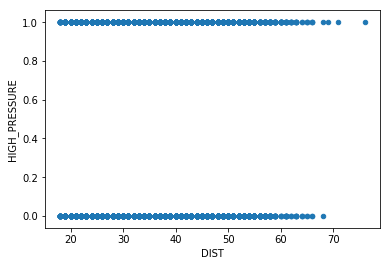

In [23]:
df.plot(x='DIST', y='HIGH_PRESSURE', kind='scatter')

In [ ]:
sql='''
SELECT FKICKER, (SUM(SUCCESS) / COUNT(*) * 100) AS SUCCESS_PERCENTAGE, 
 SUM(SUCCESS) SUCCESS_COUNT, SUM(HIGH_PRESSURE) AS HIGH_PRESSURE_COUNT,SUM(BLOCKED) AS BLOCKED_COUNT,COUNT(*) AS COUNT
 FROM (
		SELECT FGXP, PBP.GID, PBP.FKICKER, PNAME AS KICKER_NAME, DIST, QTR, MIN, TIMO AS TIMO_REMAIN,
		CASE WHEN GOOD = 'Y' THEN 1 ELSE 0 END AS SUCCESS,
		CASE WHEN DETAIL LIKE '%BLOCKED%' THEN 1 ELSE 0 END AS BLOCKED,
		CASE WHEN DPOS = 0 THEN 'UNDRAFTED' ELSE DPOS END AS DRAFT_POSITION,
		DIST - (100 - CASE WHEN YFOG = '' THEN '98' ELSE YFOG END) AS YDS_BEHIND_LOS,
		PTSO - PTSD AS POINT_DIFFERENTIAL,
		CASE WHEN QTR IN ('2' , '4') AND MIN <= 2 AND (PTSO - PTSD) >= - 3 THEN 1 ELSE 0 END AS HIGH_PRESSURE,
		TEMP, HUMD, WSPD, WDIR, COND, SURF, DETAIL
		FROM PBP
		LEFT OUTER JOIN PLAYER PLAYER ON PBP.FKICKER = PLAYER.PLAYER
		LEFT OUTER JOIN GAME ON PBP.GID = GAME.GID
		WHERE TYPE = 'FGXP')
 AS KICKER
 GROUP BY FKICKER 
 ORDER BY SUCCESS_COUNT DESC'''
